In [1]:
from abc import ABC, abstractmethod
from enum import Enum
from random import expovariate, uniform, randint, sample, choices

In [2]:
class Subject(ABC):
    def __init__(self):
        self.subscribers = set()
    
    def attach(self, o):
        self.subscribers.add(o)
    
    def detach(self, o):
        self.subscribers.remove(o)
        
    def notify(self, message):
        for subscriber in self.subscribers:
            subscriber.update(message)
        

class Person(Subject):
    MAX_TEMPERATURE_TO_SURVIVE = 44.0
    LOWEST_WATER_PCT_TO_SURVIVE = 0.4
    
    LIFE_THREATENING_TEMPERATURE = 40.0
    LIFE_THREATENING_WATER_PCT = 0.5
    
    def __init__(self, home_position=(0, 0), age=30, weight=70):
        super(Person, self).__init__()
        self.virus = None
        self.antibody_types = set()
        self.temperature = 36.6
        self.weight = weight
        self.water = 0.6 * self.weight
        self.age = age
        self.home_position = home_position
        self.position = home_position
        self.state = Healthy(self)
    
    def day_actions(self):
        self.state.day_actions()

    def night_actions(self):
        self.state.night_actions()

    def interact(self, other):
        self.state.interact(other)

    def get_infected(self, virus):
        self.state.get_infected(virus)
    
    def is_close_to(self, other):
        return self.position == other.position
    
    def fightvirus(self):
        if self.virus:
            self.virus.strength -= (3.0 / self.age)
        
    def progress_disease(self):
        if self.virus:
            self.virus.cause_symptoms(self)

    def set_state(self, state):
        self.notify('Previous state: ' + str(self.state) + '\nNew state: ' + str(state))
        self.state = state
    
    def is_life_threatening_condition(self):
        return self.temperature >= Person.LIFE_THREATENING_TEMPERATURE or \
            self.water / self.weight <= Person.LIFE_THREATENING_WATER_PCT
    
    def is_life_incompatible_condition(self):        
        return self.temperature >= Person.MAX_TEMPERATURE_TO_SURVIVE or \
            self.water / self.weight <= Person.LOWEST_WATER_PCT_TO_SURVIVE
    
class DefaultPerson(Person): pass

class CommunityPerson(Person):
    def __init__(self, community_position=(0, 0), **kwargs):
        super().__init__(**kwargs)
        self.community_position = community_position

In [3]:
class AbstractPersonFactory(ABC):
    def __init__(self, min_j, max_j, min_i, max_i):
        self.min_age, self.max_age = 1, 90
        self.min_weight, self.max_weight = 30, 120
        self.min_j, self.max_j, self.min_i, self.max_i = min_j, max_j, min_i, max_i

    @abstractmethod
    def get_person(self) -> Person:
        pass

    
class DefaultPersonFactory(AbstractPersonFactory):
    def get_person(self) -> Person:
        return DefaultPerson(
            home_position=(randint(self.min_j, self.max_j), randint(self.min_i, self.max_i)),
            age=randint(self.min_age, self.max_age),
            weight=randint(self.min_weight, self.max_weight),
        )


class CommunityPersonFactory(AbstractPersonFactory):
    def __init__(self, *args, community_position=(0, 0)):
        super().__init__(*args)
        self.community_position = community_position

    def get_person(self) -> Person:
        return CommunityPerson(
            home_position=(randint(self.min_j, self.max_j), randint(self.min_i, self.max_i)),
            age=randint(self.min_age, self.max_age),
            weight=randint(self.min_weight, self.max_weight),
            community_position=self.community_position
        )
    
def create_persons(min_j, max_j, min_i, max_i, n_persons):
    factory_params = (min_j, max_j, min_i, max_i)
    
    default_factory = DefaultPersonFactory(*factory_params)
    community_factory = CommunityPersonFactory(*factory_params, community_position=(50, 50))

    n_default_persons = int(n_persons * 0.75)
    n_community_persons = n_persons - n_default_persons

    persons = []
    for i in range(n_default_persons):
        persons.append(default_factory.get_person())
        
    for i in range(n_community_persons):
        persons.append(community_factory.get_person())

    return persons

In [4]:
class Infectable(ABC):
    def __init__(self, strength=1.0, contag=1.0):
        # contag is for contagiousness so we have less typos
        self.strength = strength
        self.contag = contag

    @abstractmethod
    def cause_symptoms(self, person):
        pass
    
    
class SeasonalFluVirus(Infectable):
    def cause_symptoms(self, person):
        person.temperature += 0.25

    def get_type(self):
        return InfectableType.SeasonalFlu
    
    
class SARSCoV2(Infectable):
    def cause_symptoms(self, person):
        person.temperature += 0.5

    def get_type(self):
        return InfectableType.SARSCoV2


class Cholera(Infectable):
    def cause_symptoms(self, person):
        person.water -= 1.0

    def get_type(self):
        return InfectableType.Cholera
    

class InfectableType(Enum):
    SeasonalFlu = 1
    SARSCoV2 = 2
    Cholera = 3

    
def get_infectable(infectable_type: InfectableType):
    if InfectableType.SeasonalFlu == infectable_type:
        return SeasonalFluVirus(strength=expovariate(10.0), contag=expovariate(10.0))
    
    elif InfectableType.SARSCoV2 == infectable_type:
        return SARSCoV2(strength=expovariate(2.0), contag=expovariate(2.0))
    
    elif InfectableType.Cholera == infectable_type:
        return Cholera(strength=expovariate(2.0), contag=expovariate(2.0))
    
    else:
        raise ValueError()

In [5]:
class Drug(ABC):
    def apply(self, person):
        # somehow reduce person's symptoms
        pass


class AntipyreticDrug(Drug): pass


class Aspirin(AntipyreticDrug):
    '''A cheaper version of the fever/pain killer.'''
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.5
        
    def apply(self, person):
        person.temperature = max(36.6, person.temperature - self.dose * self.efficiency)


class Ibuprofen(AntipyreticDrug):
    '''A more efficient version of the fever/pain killer.'''
    def __init__(self, dose):
        self.dose = dose
        
    def apply(self, person):
        person.temperature = 36.6


class RehydrationDrug(Drug): pass

class Glucose(RehydrationDrug):
    '''A cheaper version of the rehydration drug.'''
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.1
        
    def apply(self, person):
        person.water = min(person.water + self.dose * self.efficiency,
                            0.6 * person.weight)


class Rehydron(RehydrationDrug):
    '''A more efficient version of the rehydration drug.'''
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 1.0
        
    def apply(self, person):
        person._water = 0.6 * person.weight


class AntivirusDrug(Drug): pass

class Placebo(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose

    def apply(self, person): pass


class AntivirusSeasonalFlu(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 1.0
        
    def apply(self, person):
        if isinstance(person.virus, SeasonalFluVirus):
            person.virus.strength -= self.dose * self.efficiency
            
        elif isinstance(person.virus, SARSCoV2):
            person.virus.strength -= self.dose * self.efficiency / 10.0


class AntivirusSARSCoV2(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.1
        
    def apply(self, person):
        if isinstance(person.virus, SARSCoV2):
            person.virus.strength -= self.dose * self.efficiency


class AntivirusCholera(AntivirusDrug):
    def __init__(self, dose):
        self.dose = dose
        self.efficiency = 0.1
        
    def apply(self, person):
        if isinstance(person.virus, Cholera):
            person.virus.strength -= self.dose * self.efficiency

In [6]:
from typing import List


class DrugRepository(ABC):
    def __init__(self):
        self.treatment = []
        
    @abstractmethod
    def get_antifever(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_rehydration(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_seasonal_antivirus(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_sars_antivirus(self, dose) -> Drug: pass
    
    @abstractmethod
    def get_cholera_antivirus(self, dose) -> Drug: pass
    
    def get_treatment(self):
        return self.treatment


class CheapDrugRepository(DrugRepository):
    def get_antifever(self, dose) -> Drug:
        return Aspirin(dose)

    def get_rehydration(self, dose) -> Drug:
        return Glucose(dose)

    def get_seasonal_antivirus(self, dose) -> Drug:
        return Placebo(dose)

    def get_sars_antivirus(self, dose) -> Drug:
        return Placebo(dose)

    def get_cholera_antivirus(self, dose) -> Drug:
        return Placebo(dose)


class ExpensiveDrugRepository(DrugRepository):
    def get_antifever(self, dose) -> Drug:
        return Ibuprofen(dose)

    def get_rehydration(self, dose) -> Drug:
        return Rehydron(dose)

    def get_seasonal_antivirus(self, dose) -> Drug:
        return AntivirusSeasonalFlu(dose)

    def get_sars_antivirus(self, dose) -> Drug:
        return AntivirusSARSCoV2(dose)

    def get_cholera_antivirus(self, dose) -> Drug:
        return AntivirusCholera(dose)

In [7]:
class AbstractPrescriptor(ABC):
    def __init__(self, drug_repository):
        self.drug_repository = drug_repository
        
    @abstractmethod
    def create_prescription(self) -> List[Drug]:
        pass
    

class SeasonalFluPrescriptor(AbstractPrescriptor):
    def __init__(self, drug_repository, antifever_dose=1.0, antivirus_dose=1.0):
        super().__init__(drug_repository)
        self.antifever_dose = antifever_dose
        self.antivirus_dose = antivirus_dose

    def create_prescription(self) -> List[Drug]:
        return [
            self.drug_repository.get_antifever(self.antifever_dose),
            self.drug_repository.get_seasonal_antivirus(self.antivirus_dose)
        ]

    
class CovidPrescriptor(AbstractPrescriptor):
    def __init__(self, drug_repository, antifever_dose=1.0, antivirus_dose=1.0):
        super().__init__(drug_repository)
        self.antifever_dose = antifever_dose
        self.antivirus_dose = antivirus_dose

    def create_prescription(self) -> List[Drug]:
        return [
            self.drug_repository.get_antifever(self.antifever_dose),
            self.drug_repository.get_sars_antivirus(self.antivirus_dose)
        ]


class CholeraPrescriptor(AbstractPrescriptor):
    def __init__(self, drug_repository, rehydradation_dose=1.0, antivirus_dose=1.0):
        super().__init__(drug_repository)
        self.rehydradation_dose = rehydradation_dose
        self.antivirus_dose = antivirus_dose

    def create_prescription(self) -> List[Drug]:
        return [
            self.drug_repository.get_rehydration(self.rehydradation_dose),
            self.drug_repository.get_cholera_antivirus(self.antivirus_dose)
        ]


def get_prescription_method(disease_type, drug_repository):
    if InfectableType.SeasonalFlu == disease_type:
        return SeasonalFluPrescriptor(drug_repository)

    elif InfectableType.SARSCoV2 == disease_type:
        return CovidPrescriptor(drug_repository)

    elif InfectableType.SARSCoV2 == disease_type:
        return CholeraPrescriptor(drug_repository)

    else:
        raise ValueError()

In [8]:
class Hospital:
    def __init__(self, capacity, drug_repository):
        # self.doctor = doctor
        self.drug_repository = drug_repository
        self.capacity = capacity
        self.patients = []
        # self.tests = []

    def _treat_patient(self, patient):
        # 1. identify disease
        if patient.virus is not None:
            disease_type = patient.virus.get_type()
        else:
            self.patients.remove(patient)
            return
        prescription_method = get_prescription_method(disease_type, self.drug_repository)
        
        # 2. understand dose
        
        # 3. compose treatment
        prescription_drugs = prescription_method.create_prescription()
        
        # 4. apply treatment
        for drug in prescription_drugs:
            #patient.take_drug(drug)
            drug.apply(patient)

    def treat_patients(self):
        for patient in self.patients:
            self._treat_patient(patient)

In [9]:
import re

class Observer(ABC): 
    
    @abstractmethod
    def update(message):
        pass
    

class DepartmentOfHealth(Observer):
    def __init__(self, hospitals, people):
        if(self.__initialized): return
        self.__initialized = True
        
        self.hospitals = hospitals
        self.people = people
        
        self.infected_counts = [0]
        self.hospitalized_counts = [0]
        self.dead_counts = [0]
        self.recovered_counts = [0]
        self.antibodies_counts = [0]
        
        self.day = 0
    
    def monitor_situation(self):
        for person in self.people:
            person.attach(self)
    
    def issue_policy(self):
        pass

    def new_day(self):
        self.day += 1
        
        for arr in [self.infected_counts, 
                    self.hospitalized_counts, 
                    self.dead_counts, 
                    self.recovered_counts, 
                    self.antibodies_counts]:
            # if no new infected/hospitalized/etc. people during the last day, 
            # update the lists to reflect that new day has come
            if len(arr) < self.day:
                arr.append(arr[-1])
    
    def update(self, message):
        _, previous_state, _, new_state = re.split(': |\n', message)
        if new_state == 'Asymptomatic sick':
            self.infected_counts[-1] += 1
        elif new_state == 'Hospitalized':
            self.hospitalized_counts[-1] += 1
        elif new_state == 'Dead':
            self.dead_counts[-1] += 1
        elif new_state == 'Healthy':
            self.recovered_counts[-1] += 1
            self.antibodies_counts[-1] += 1
            if previous_state == 'Hospitalized':
                self.hospitalized_counts[-1] -= 1
    
    def hospitalize(self, person):
        for hospital in self.hospitals:
            if hospital.capacity >= len(hospital.patients):
                hospital.patients.append(person)
                person.set_state(Hospitalized(person))
    
    __instance = None
    def __new__(cls, *args, **kwargs):
        if cls.__instance is None:
            cls.__instance = super(DepartmentOfHealth, cls).__new__(cls)
            cls.__instance.__initialized = False
        return cls.__instance

In [10]:
class GlobalContext:
    def __init__(self, canvas=None, persons=None, health_dept=None):      
        if(self.__initialized): return
        self.__initialized = True
        
        self.canvas = canvas
        self.persons = persons
        self.health_dept = health_dept
        
    __instance = None
    def __new__(cls, *args, **kwargs):
        if cls.__instance is None:
            cls.__instance = super(GlobalContext, cls).__new__(cls)
            cls.__instance.__initialized = False
        return cls.__instance

In [11]:
class State(ABC):
    def __init__(self, person): 
        self.person = person
        
    @abstractmethod
    def day_actions(self): pass

    @abstractmethod
    def night_actions(self): pass

    @abstractmethod
    def interact(self, other): pass

    @abstractmethod
    def get_infected(self, virus): pass


class Healthy(State):
    def day_actions(self):
        # different for CommunityPerson?!
        if isinstance(self.person, CommunityPerson):
            self.person.position = self.person.community_position
        else:
            min_j, max_j, min_i, max_i = GlobalContext().canvas[:4]
            # I did not figure out they way of accessing canvas that fits with the singleton pattern
            #min_j, max_j, min_i, max_i = GlobalContext.__instance.canvas[:4]
            self.person.position = (randint(min_j, max_j), 
                                    randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position

    def interact(self, other: Person): pass

    def get_infected(self, virus):
        if virus.get_type() not in self.person.antibody_types:
            self.person.virus = virus
            self.person.set_state(AsymptomaticSick(self.person))
               
    def __str__(self):
        return 'Healthy'


class AsymptomaticSick(State):
    DAYS_SICK_TO_FEEL_BAD = 2
    
    def __init__(self, person):
        super().__init__(person)
        self.days_sick = 0

    def day_actions(self):
        # different for CommunityPerson?!
        if isinstance(self.person, CommunityPerson):
            self.person.position = self.person.community_position
        else:
            min_j, max_j, min_i, max_i = GlobalContext().canvas[:4]
            self.person.position = (randint(min_j, max_j), randint(min_i, max_i))

    def night_actions(self):
        self.person.position = self.person.home_position
        if self.days_sick == AsymptomaticSick.DAYS_SICK_TO_FEEL_BAD:
            self.person.set_state(SymptomaticSick(self.person))
        self.days_sick += 1

    def interact(self, other):
        other.get_infected(self.person.virus)

    def get_infected(self, virus): pass
    
    def __str__(self):
        return 'Asymptomatic sick'


class SymptomaticSick(State):
    def day_actions(self):
        self.person.progress_disease()
        
        if self.person.is_life_threatening_condition():
            health_dept = GlobalContext().health_dept
            health_dept.hospitalize(self.person)

        if self.person.is_life_incompatible_condition():
            self.person.set_state(Dead(self.person))
        
    def night_actions(self):
        # try to fight the virus
        self.person.fightvirus()
        if self.person.virus.strength <= 0:
            self.person.set_state(Healthy(self.person))
            self.person.antibody_types.add(self.person.virus.get_type())
            self.person.virus = None

    def interact(self, other): pass

    def get_infected(self, virus): pass
    
    def __str__(self):
        return 'Symptomatic sick'
    

class Hospitalized(SymptomaticSick):
    def day_actions(self):
        self.person.progress_disease()
        
        if self.person.is_life_incompatible_condition():
            self.person.set_state(Dead(self.person))
            
    def __str__(self):
        return 'Hospitalized'

    
class Dead(State):
    def day_actions(self): pass

    def night_actions(self): pass

    def interact(self, other): pass

    def get_infected(self, virus): pass
    
    def __str__(self):
        return 'Dead'


In [12]:
# def create_persons(min_j, max_j, min_i, max_i, n_persons):
#     min_age, max_age = 1, 90
#     min_weight, max_weight = 30, 120
#     persons = [
#         Person(
#             canvas=(min_j, max_j, min_i, max_i),
#             home_position=(randint(min_j, max_j), randint(min_i, max_i)),
#             age=randint(min_age, max_age),
#             weight=randint(min_weight, max_weight),
#         )
#         for i in range(n_persons)
#     ]
#     return persons


def create_department_of_health(hospitals, persons):
    return DepartmentOfHealth(hospitals, persons)


def create_hospitals(n_hospitals):
    drug_repository_types = choices([CheapDrugRepository, ExpensiveDrugRepository], k=n_hospitals)
    hospitals = [
        Hospital(capacity=50, drug_repository=drug_repository_types[i]())
        for i in range(n_hospitals)
    ]
    return hospitals

See implementations of Person and DepartmentOfHealth classes

## 3. Simulation

In [13]:
def initialize():
    # our little country
    min_i, max_i = 0, 23
    min_j, max_j = 0, 23
    
    # our citizen
    n_persons = 500
    persons = create_persons(min_j, max_j, min_i, max_i, n_persons)
    
    viruses = []
    for virus_type in [InfectableType.SeasonalFlu, InfectableType.SARSCoV2, InfectableType.Cholera]:
        viruses.append(get_infectable(virus_type))
        
    # our healthcare system
    n_hospitals = 4
    hospitals = create_hospitals(n_hospitals)
        
    health_dept = create_department_of_health(hospitals, persons)
    health_dept.monitor_situation()
 
    persons_to_be_infected = sample(persons, 3)
    for person, virus in zip(persons_to_be_infected, viruses):
        person.get_infected(virus)
    
    # global context
    context = GlobalContext(
        canvas=(min_j, max_j, min_i, max_i),
        persons=persons,
        health_dept=health_dept
    )

    return context

def simulate_day(context):
    persons, health_dept, hospitals = context.persons, context.health_dept, context.health_dept.hospitals

    # health_dept.issue_policy()
    health_dept.new_day()
    
    for hospital in hospitals:
        hospital.treat_patients()
    
    for person in persons:
        person.day_actions()
    
    for person in persons:
        for other in persons:
            if person is not other and person.is_close_to(other):
                person.interact(other)
                
    for person in persons:
        person.night_actions()
        
context = initialize()

In [29]:
for day in range(100):
    #print('day {}'.format(day + 1))
    simulate_day(context)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
health_dept = context.health_dept

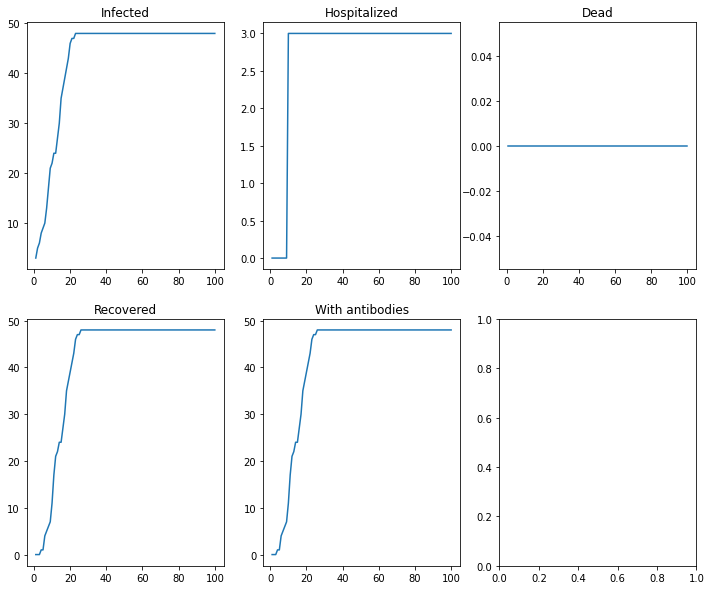

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
lists = [health_dept.infected_counts, health_dept.hospitalized_counts, health_dept.dead_counts, 
         health_dept.recovered_counts, health_dept.antibodies_counts]
labels = ['Infected', 'Hospitalized', 'Dead', 'Recovered', 'With antibodies']
for i, (label, l) in enumerate(zip(labels, lists)):
    axs[i // 3][i % 3].set_title(label)
    axs[i // 3][i % 3].plot(np.arange(100) + 1, l)

plt.show()

In [28]:
import unittest

'''
Mikhail Kirillov part
Testing #3 and #4 functions
'''

def initialize_test_context():
    # our little country
    min_i, max_i = 0, 0
    min_j, max_j = 0, 0
    
    # our citizen
    n_persons = 2
    persons = create_persons(min_j, max_j, min_i, max_i, n_persons)
    
    viruses = []
    for virus_type in [InfectableType.SeasonalFlu, InfectableType.SARSCoV2, InfectableType.Cholera]:
        viruses.append(get_infectable(virus_type))
 
    persons_to_be_infected = sample(persons, 1)
    for person, virus in zip(persons_to_be_infected, viruses):
        person.get_infected(virus)
    
    # global context
    context = GlobalContext(
        canvas=(min_j, max_j, min_i, max_i),
        persons=persons,
        health_dept=health_dept
    )

    return context

context = initialize_test_context()

class InfectedPersonContactsAntibodies(unittest.TestCase):
    def test_valid_input(self):
        infected_person = 0
        person_with_antibodies = 0
#state = freeze_state_of_latter(person_with_antibodies)
        #infected_person.interact(person_with_antibodies)
        self.assertEqual(1,1)




.
----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


In [ ]:
'''
Mark Zakharov part
Testing #1 and #2 functions
'''

In [ ]:
'''
Mikhail Kuimov part
Testing #5 and #6 functions
'''

In [ ]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)